In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import tempfile

from six.moves import urllib
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.model_selection import GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import normalize

%matplotlib inline
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, K
from keras.layers import Dense, Activation, BatchNormalization, Input, Dropout, Embedding, merge, Merge, Flatten
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
import utils; reload(utils)

<module 'utils' from 'utils.pyc'>

In [4]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]
LABEL_COLUMN = "label"
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
CONTINUOUS_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]

In [5]:
df_train = pd.read_csv('train.data', names=COLUMNS, skipinitialspace=True)
df_test = pd.read_csv('test.data', names=COLUMNS, skipinitialspace=True, skiprows=1)

# remove NaN elements
df_train = df_train.dropna(how='any', axis=0)
df_test = df_test.dropna(how='any', axis=0)

df_train[LABEL_COLUMN] = (
  df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test[LABEL_COLUMN] = (
  df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0


In [6]:
def convert_dataframe(dataframe, normalize=False):
    df_cat_one_hot = pd.get_dummies(dataframe[CATEGORICAL_COLUMNS])
    df_continous_cols = dataframe[CONTINUOUS_COLUMNS]
    df_one_hot = pd.concat([df_continous_cols, df_cat_one_hot], axis=1)
    print("shape: %s" % (df_one_hot.shape,))
    return df_one_hot

X_train = convert_dataframe(df_train, normalize=True)
X_test = convert_dataframe(df_test, normalize=True)

shape: (15174, 106)
shape: (16281, 106)


In [7]:
X_test.head(2)

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,25,7,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,50,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [8]:
y_train, y_test = df_train[LABEL_COLUMN].values, df_test[LABEL_COLUMN].values
y_train.shape, y_test.shape

((15174,), (16281,))

In [9]:
def fully_connected(dense_size, input):
    x = BatchNormalization()(input)
    x = Dense(dense_size, activation='relu')(x)
    return Dropout(0.5)(x)

## Fully connected model with categorical columns as one-hot encodings

In [156]:
input = Input(shape=(X_train.shape[1],))
hidden1 = fully_connected(50, input)
hidden2 = fully_connected(25, hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

simple_model = Model(input, output)

optimizer = Adam(lr=1e-3)
simple_model.compile(loss='binary_crossentropy', 
                     optimizer=optimizer, 
                     metrics=['accuracy'])
simple_model.fit(X_train.values, y_train,
                nb_epoch=10, batch_size=64,
                validation_data=(X_test.values, y_test))

Train on 15174 samples, validate on 16281 samples
Epoch 1/10
15174/15174 [==============================] - 13s - loss: 0.5252 - acc: 0.7349 - val_loss: 0.3732 - val_acc: 0.8333

In [157]:
K.set_value(embeddings_model.optimizer.lr, 1e-4)
simple_model.fit(X_train.values, y_train,
                nb_epoch=5, batch_size=64,
                validation_data=(X_test.values, y_test))

Train on 15174 samples, validate on 16281 samples
Epoch 1/5
15174/15174 [==============================] - 3s - loss: 0.3451 - acc: 0.8395 - val_loss: 0.3343 - val_acc: 0.8484

In [158]:
K.set_value(embeddings_model.optimizer.lr, 1e-5)
simple_model.fit(X_train.values, y_train,
                nb_epoch=5, batch_size=64,
                validation_data=(X_test.values, y_test))

Train on 15174 samples, validate on 16281 samples
Epoch 1/5
15174/15174 [==============================] - 3s - loss: 0.3435 - acc: 0.8432 - val_loss: 0.3359 - val_acc: 0.8497

## Results:

#### Best test set log loss from is around 0.336, accuracy around 85.1%

Let's draw the model graph:

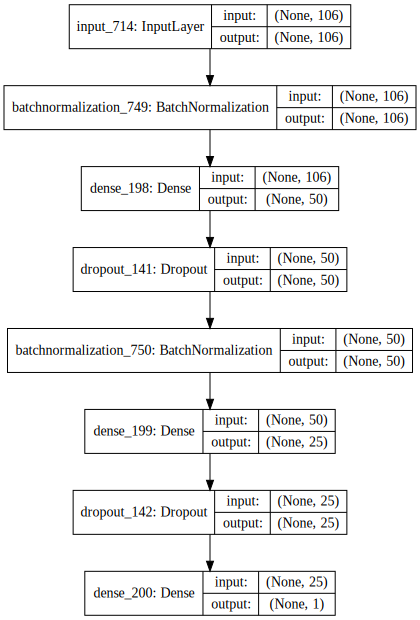

In [150]:
utils.draw_model_graph(simple_model)

## Fully connected model with categorical columns represented as embeddings

In [104]:
class DatasetHelper():
    def __init__(self, dataset, dropout_val=0.5, continous_columns_hidden_layer_size=100):
        self.dataset = dataset
        self.dataset_len = len(self.dataset)
        self.dropout_val = dropout_val
        self.continous_columns_hidden_layer_size = continous_columns_hidden_layer_size
        self.embedding_sizes = self.__embedding_sizes()
        
        self.__categorical_columns_input_data = []
        self.__categorical_inputs = []
        self.__embedding_layers = []
        
        for col in self.dataset[CATEGORICAL_COLUMNS].columns:
            col_str_vals = self.dataset[col]
            col_values = pd.factorize(col_str_vals)[0]
            self.__categorical_columns_input_data.append(col_values)
            
            input = Input(shape=(1,))
            x = Embedding(len(col_values), self.embedding_sizes[col])(input)
            x = BatchNormalization()(x)
            output = Flatten()(x)

            self.__categorical_inputs.append(input)
            self.__embedding_layers.append(output)
        
        self.__continous_columns_data = self.dataset[CONTINUOUS_COLUMNS].values
        self.continous_columns_input, self.continous_columns_output = self.continous_columns_model()
        
    def all_columns_input_data(self):
        '''
        First returns arrays with categorical data, 
        last element of the array contains all continous data
        '''
        columns = []
        columns += self.__categorical_columns_input_data
        columns.append(self.__continous_columns_data)
        return columns
    
    def all_models(self):
        layers = []
        layers += self.__embedding_layers
        layers.append(self.continous_columns_output)
        return layers
    
    def all_inputs_tensors(self):
        inputs = []
        inputs += self.__categorical_inputs
        inputs.append(self.continous_columns_input)
        return inputs

    def continous_columns_model(self):
        input = Input(shape=(self.__continous_columns_data.shape[1],))
        x = BatchNormalization()(input)
        x = Dense(self.continous_columns_hidden_layer_size, activation='relu')(x)
        model_output = Dropout(self.dropout_val)(x)
        return (input, model_output)
    
    def __embedding_sizes(self):
        '''
        Builds a dict for all categorical columns. Each dict value contains
        calculated embedding size. Size is calculated basing on length of uniq
        values in categorical column, divided by 3
        '''
        embedding_size_dict = {}
        for col in self.dataset[CATEGORICAL_COLUMNS].columns:
            col_str_vals = self.dataset[col]
            col_uniq_values = len(np.unique(pd.factorize(col_str_vals)[0]))
            embedding_size = col_uniq_values // 4
            if embedding_size < 2:
                embedding_size = 2
            embedding_size_dict[col] = embedding_size
        print("Embedding sizes for each of categorical columns:")
        print(embedding_size_dict)    
        return embedding_size_dict

In [136]:
X_train_helper = DatasetHelper(df_train, continous_columns_hidden_layer_size=150, dropout_val=0.5)
X_test_helper = DatasetHelper(df_test)

Embedding sizes for each of categorical columns:
{'workclass': 2, 'relationship': 2, 'gender': 2, 'marital_status': 2, 'race': 2, 'native_country': 10, 'education': 4, 'occupation': 3}
Embedding sizes for each of categorical columns:
{'workclass': 2, 'relationship': 2, 'gender': 2, 'marital_status': 2, 'race': 2, 'native_country': 10, 'education': 4, 'occupation': 3}


In [137]:
merged_inputs = merge(X_train_helper.all_models(), mode='concat')
hidden1 = fully_connected(300, merged_inputs)
output = Dense(1, activation='sigmoid')(hidden1)

embeddings_model = Model(X_train_helper.all_inputs_tensors(), output)

optimizer = Adam(lr=1e-4)
embeddings_model.compile(loss='binary_crossentropy', 
                     optimizer=optimizer, 
                     metrics=['accuracy'])
embeddings_model.fit(X_train_helper.all_columns_input_data(), y_train, 
                nb_epoch=3, batch_size=32,
                validation_data=(X_test_helper.all_columns_input_data(), y_test))

Train on 15174 samples, validate on 16281 samples
Epoch 1/3
15174/15174 [==============================] - 24s - loss: 0.5239 - acc: 0.7414 - val_loss: 0.3949 - val_acc: 0.8211

In [153]:
# K.set_value(embeddings_model.optimizer.lr, 1e-5)
# embeddings_model.fit(X_train_helper.all_columns_input_data(), y_train, 
#                 nb_epoch=1, batch_size=32,
#                 validation_data=(X_test_helper.all_columns_input_data(), y_test))

## Embeddings model graph

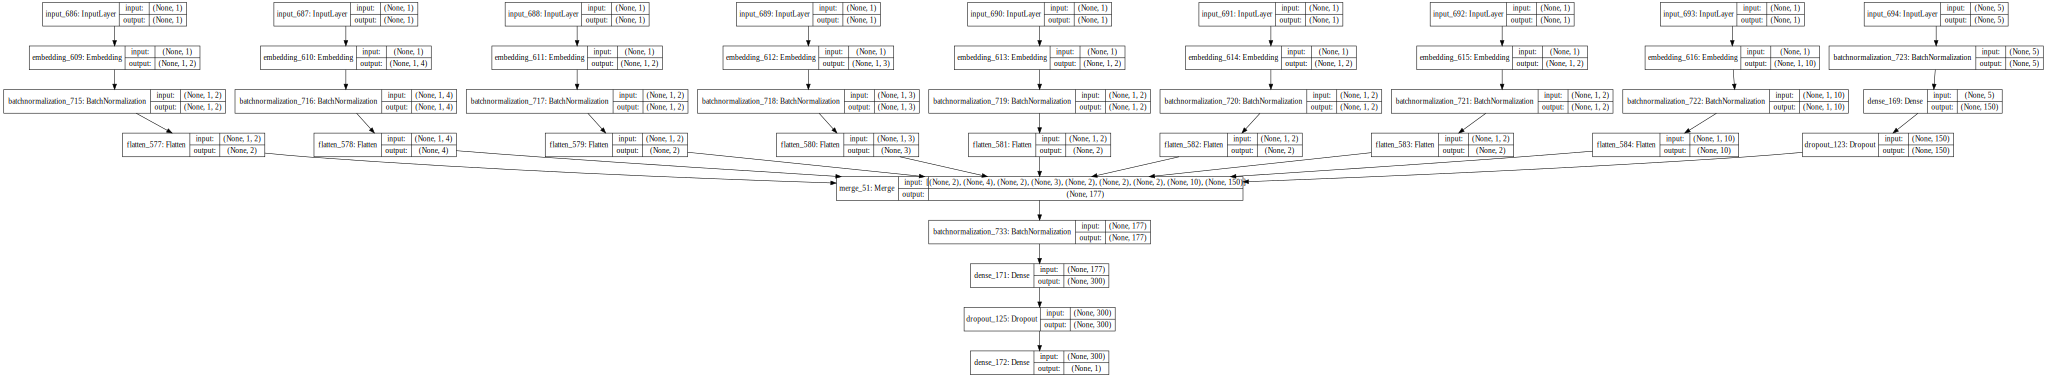

In [151]:
utils.draw_model_graph(embeddings_model)

## Summary

* Simple model with one-hot encodings perform better than version with embeddings

* Simple model best log loss accuracy is 85.1%

* XGBoost version performed better than Deep Neural Network version reaching accuracy 86.1% on test set